In [2]:
!pip3 install gymnasium
!pip3 install numpy
!pip3 install IPython
!pip3 install matplotlib
!pip3 install keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [23]:
!pip3 install tensorflow

# **Applying Needed Libraries**

In [5]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython import display

# **Arranging Params**

In [6]:

# Deep Q-Learning parametreleri
gamma = 0.95  # İndirim oranı
epsilon = 1.0  # Keşif oranı başlangıç değeri
epsilon_min = 0.01  # Minimum keşif oranı
epsilon_decay = 0.995  # Keşif oranı azalma hızı
learning_rate = 0.001  # Öğrenme hızı
batch_size = 64  # Mini-batch boyutu
memory_size = 2000  # Replay buffer boyutu

# **Creating Environment & Neural Links**

In [7]:
# Ortamı oluştur
import gymnasium as gym

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]  # Durum uzayının boyutu
action_size = env.action_space.n  # Aksiyon uzayının boyutu

# Replay buffer (deneyim tekrarı için)
memory = deque(maxlen=memory_size)  # FIFO veri yapısı

# Q-ağını (sinir ağı) oluştur
model = Sequential([
    Input(shape=(state_size,)),
    Dense(24, activation='relu'),  # İlk gizli katman
    Dense(24, activation='relu'),  # İkinci gizli katman
    Dense(action_size, activation='linear')  # Çıkış katmanı
])

model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))  # Modeli derle


# **Policy & Replay Buffer**

In [8]:
# Ajanın hareketini belirleyen politika fonksiyonu
def act(state):
    if np.random.rand() <= epsilon:  # Epsilon-greedy politika
        return env.action_space.sample()  # Rastgele aksiyon seç
    act_values = model.predict(state)  # Modelden aksiyon değerlerini tahmin et
    return np.argmax(act_values[0])  # En iyi aksiyonu seç

# Deneyimleri replay buffer'a ekleme ve ağın eğitimi
def replay():
    global epsilon
    if len(memory) < batch_size:  # Replay buffer yeterince büyük değilse geri dön
        return
    minibatch = random.sample(memory, batch_size)  # Replay buffer'dan rastgele örnekler al
    for state, action, reward, next_state, done in minibatch:
        target = reward  # Hedef ödül
        if not done:
            target = (reward + gamma * np.amax(model.predict(next_state)[0]))  # Hedefi güncelle
        target_f = model.predict(state)  # Mevcut tahmin
        target_f[0][action] = target  # Tahmini hedef ile güncelle
        model.fit(state, target_f, epochs=1, verbose=0)  # Modeli eğit
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay  # Epsilon'u azalt

# **Initializing Agent**

In [21]:
# Ajanı çalıştır
episodes = 1000  # Eğitim döngüsü sayısı
scores = []  # Bölüm sonuçlarını depolamak için liste
for e in range(episodes):
    state, _ = env.reset()  # Ortamı sıfırla ve başlangıç durumunu al
    print(f"Initial state: {state}")

    # State'in numpy array'e dönüştürülmesi ve yeniden şekillendirilmesi
    if isinstance(state, list):
        state = np.array(state, dtype=object)
    elif isinstance(state, tuple):  # Eğer state bir tuple ise
        state = np.array(state)
    if state.ndim == 1:  # Eğer tek boyutlu ise
        state = np.reshape(state, [1, state_size])

    score = 0  # Bölüm puanı
    for time in range(500):  # Her bölümde maksimum adım sayısı
        action = env.action_space.sample()  # Rastgele aksiyon seç
        step_result = env.step(action)  # Aksiyonu uygula ve sonucu al

        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        elif len(step_result) == 5:
            next_state, reward, done, _, _ = step_result
        else:
            raise ValueError(f"Unexpected number of values from env.step(action): {len(step_result)}")

        reward = reward if not done else -10  # Ödülü güncelle

        print(f"Next state: {next_state}")

        # Next_state'in numpy array'e dönüştürülmesi ve yeniden şekillendirilmesi
        if isinstance(next_state, list):
            next_state = np.array(next_state, dtype=object)
        elif isinstance(next_state, tuple):  # Eğer next_state bir tuple ise
            next_state = np.array(next_state)
        if next_state.ndim == 1:  # Eğer tek boyutlu ise
            next_state = np.reshape(next_state, [1, state_size])

        state = next_state  # Durumu güncelle
        score += reward  # Puanı güncelle
        if done:  # Eğer bölüm sonlandıysa
            print(f"episode: {e}/{episodes}, score: {score}")  # Bölüm bilgisini yazdır
            scores.append(score)  # Bölüm sonucunu kaydet
            break

    # Her 50 bölümde bir performansı göster
    if e % 50 == 0:
        env.render()  # Ortamı görselleştir

env.close()  # Ortamı kapat


Initial state: [-0.02577285  0.02097391  0.04644874 -0.00788978]
Next state: [-0.02535337 -0.17478234  0.04629095  0.2990789 ]
Next state: [-0.02884902 -0.3705325   0.05227252  0.60599434]
Next state: [-0.03625967 -0.5663449   0.06439241  0.91467285]
Next state: [-0.04758657 -0.76227593  0.08268587  1.2268785 ]
Next state: [-0.06283209 -0.9583592   0.10722344  1.5442805 ]
Next state: [-0.08199927 -1.1545937   0.13810904  1.8684051 ]
Next state: [-0.10509115 -1.3509301   0.17547715  2.2005806 ]
Next state: [-0.13210975 -1.1578791   0.21948877  1.966777  ]
episode: 0/1000, score: -3.0
Initial state: [-0.01724484 -0.00030915  0.04888821  0.02182302]
Next state: [-0.01725103 -0.19609687  0.04932468  0.32952112]
Next state: [-0.02117296 -0.391885    0.0559151   0.63734174]
Next state: [-0.02901066 -0.5877403   0.06866194  0.947096  ]
Next state: [-0.04076547 -0.39360678  0.08760385  0.6767526 ]
Next state: [-0.04863761 -0.19980425  0.1011389   0.4128862 ]
Next state: [-0.05263369 -0.3962035

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Next state: [ 0.06190151 -0.00424537 -0.08035416 -0.08938807]
Next state: [ 0.0618166  -0.1981291  -0.08214192  0.17690043]
Next state: [ 0.05785402 -0.39198533 -0.07860391  0.44258174]
Next state: [ 0.05001431 -0.5859121  -0.06975228  0.709488  ]
Next state: [ 0.03829607 -0.38989696 -0.05556252  0.3956897 ]
Next state: [ 0.03049813 -0.19403249 -0.04764872  0.08601938]
Next state: [ 0.02661748  0.00173894 -0.04592834 -0.22130789]
Next state: [ 0.02665226  0.19748627 -0.05035449 -0.5281174 ]
Next state: [ 0.03060199  0.39327917 -0.06091684 -0.8362325 ]
Next state: [ 0.03846757  0.19903983 -0.07764149 -0.56331235]
Next state: [ 0.04244836  0.00508826 -0.08890774 -0.29606515]
Next state: [ 0.04255013  0.20135777 -0.09482904 -0.61541104]
Next state: [ 0.04657729  0.00767973 -0.10713726 -0.35403723]
Next state: [ 0.04673088 -0.18576868 -0.114218   -0.09696653]
Next state: [ 0.04301551 -0.37908408 -0.11615734  0.15761007]
Next state: [ 0.0354338

# **Visualisation**

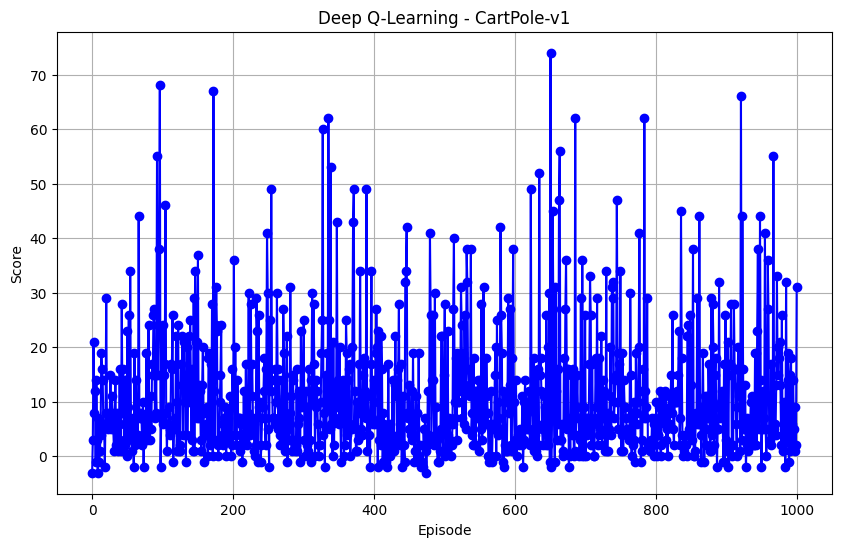

In [22]:
# Eğitim sonuçlarını çizdir
plt.figure(figsize=(10, 6))
plt.plot(scores, marker='o', linestyle='-', color='b')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Deep Q-Learning - CartPole-v1')
plt.grid(True)
plt.show()